In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from collections import deque
import random
import xgboost as xgb
from sklearn.utils import resample
import matplotlib.pyplot as plt
import optuna
import joblib
import os
import glob

# Hyperparameter Optimization of DQN Agent

In [258]:
# Parameters
state_size = 18 
action_size = 3
transaction_fee = 0.00075
initial_capital = 1000
n_ensemble = 10
stop_loss_pct = 0.05
take_profit_pct = 0.10

# Load data
X_train = pd.read_csv("data/X_train.csv")
X_test = pd.read_csv("data/X_test.csv")
y_train = pd.read_csv("data/y_train.csv")["price_direction"].values
merged_df = pd.read_csv("data/merged_data.csv")
df_test = merged_df.iloc[-len(X_test):].reset_index(drop=True)
close_prices = merged_df["CLOSE"].values[-len(X_test):]
high_prices = merged_df["HIGH"].values[-len(X_test):]
low_prices = merged_df["LOW"].values[-len(X_test):]

selected_features = ['others_dr', 'puell-multiple', 'sth-mvrv', 'lth-mvrv', 'volume_sma_em', 'trend_dpo',
                     'volatility_ui', 'lth-sopr', 'volume_em', 'cdd', 'trend_adx', 'out-flows',
                     'trend_mass_index', 'SUGAR', 'COFFEE', 'trend_stc']
X_train_selected = X_train[selected_features].values
X_test_selected = X_test[selected_features].values

# === Ensemble XGBoost model ===
params = {
    'objective': "binary:logistic",
    'learning_rate': 0.0061,
    'max_depth': 10,
    'n_estimators': 350,
    'subsample': 0.8,
    'colsample_bytree': 0.904,
    'random_state': 42
}

models = []
for i in range(n_ensemble):
    X_resampled, y_resampled = resample(X_train_selected, y_train, random_state=i)
    model_i = xgb.XGBClassifier(**params)
    model_i.fit(X_resampled, y_resampled)
    models.append(model_i)


def ensemble_predict(models, x):
    preds = np.array([m.predict_proba(x)[:, 1] for m in models])
    return preds.mean(), preds.std()

In [260]:
def objective(trial):
    # === Optimized hyperparameters ===
    units_0 = trial.suggest_int("units_0", 64, 512, step=64)
    units_1 = trial.suggest_int("units_1", 64, 512, step=64)
    per_alpha = trial.suggest_float("per_alpha", 0.4, 1.0)
    per_beta = trial.suggest_float("per_beta", 0.1, 1.0)
    epsilon_start = trial.suggest_float("epsilon_start", 0.3, 1.0)
    epsilon_end = trial.suggest_float("epsilon_end", 0.01, 0.1)
    epsilon_decay = trial.suggest_float("epsilon_decay", 0.001, 0.01)
    reward_scale = trial.suggest_float("reward_scale", 10, 50)
    good_exp = trial.suggest_float("good_exp", 0.1, 1.5)
    bad_exp = trial.suggest_float("bad_exp", 0.1, 1.5)
    no_trade_threshold = trial.suggest_float("no_trade_threshold", 0.01, 0.1)
    no_trade_factor = trial.suggest_float("no_trade_factor", 1, 8)
    gamma = trial.suggest_float("gamma", 0.8, 0.99)
    lr = trial.suggest_float("lr", 1e-5, 1e-3, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    loss_fn = trial.suggest_categorical("loss_fn", ["mse", "smoothl1"])
    atr_factor_tp = trial.suggest_float("atr_factor_tp", 0.2, 1.5)
    atr_factor_sl = trial.suggest_float("atr_factor_sl", 0.2, 1.5)
    sl_decay = trial.suggest_float("sl_decay", 0.0, 1.0)
    max_hold_days = trial.suggest_int("max_hold_days", 1, 7)
    risk_factor = trial.suggest_float("risk_factor", 0.3, 0.9)

    # === Custom network ===
    class DQNetwork(nn.Module):
        def __init__(self, input_dim, output_dim):
            super(DQNetwork, self).__init__()
            self.model = nn.Sequential(
                nn.Linear(input_dim, units_0),
                nn.ReLU(),
                nn.Linear(units_0, units_1),
                nn.ReLU(),
                nn.Linear(units_1, output_dim)
            )

        def forward(self, x):
            return self.model(x)

    # === Replay buffer ===
    class PrioritizedReplayBuffer:
        def __init__(self, max_size=10000, alpha=per_alpha):
            self.buffer = []
            self.priorities = []
            self.max_size = max_size
            self.alpha = alpha
            self.pos = 0

        def add(self, experience, td_error=1.0):
            priority = (abs(td_error) + 1e-6) ** self.alpha
            if len(self.buffer) < self.max_size:
                self.buffer.append(experience)
                self.priorities.append(priority)
            else:
                self.buffer[self.pos] = experience
                self.priorities[self.pos] = priority
                self.pos = (self.pos + 1) % self.max_size

        def sample(self, batch_size, beta=per_beta):
            if len(self.buffer) == 0:
                return [], [], [], [], [], [], []

            scaled_priorities = np.array(self.priorities)
            probs = scaled_priorities / scaled_priorities.sum()
            indices = np.random.choice(len(self.buffer), batch_size, p=probs)
            experiences = [self.buffer[i] for i in indices]

            total = len(self.buffer)
            weights = (total * probs[indices]) ** (-beta)
            weights /= weights.max()

            states, actions, rewards, next_states, dones = map(np.array, zip(*experiences))
            return (
                np.array(states),
                np.array(actions),
                np.array(rewards),
                np.array(next_states),
                np.array(dones),
                indices,
                weights
            )

        def update_priorities(self, indices, td_errors):
            for i, td in zip(indices, td_errors):
                self.priorities[i] = (abs(td) + 1e-6) ** self.alpha

        def size(self):
            return len(self.buffer)

    # === Reward ===
    def calculate_reward(pct_change, action, confidence, uncertainty):
        movement = abs(pct_change)
        correct_direction = (
            (action == 2 and pct_change > 0) or
            (action == 0 and pct_change < 0)
        )

        if action == 1:
            if movement < no_trade_threshold:
                reward = movement ** good_exp * (1 - confidence) * no_trade_factor
            else:
                reward = -(movement ** bad_exp) * (1 - confidence) * no_trade_factor
        elif correct_direction:
            reward = (movement ** good_exp) * (1 + confidence)
        else:
            reward = -(movement ** bad_exp) * (1 + confidence)

        return float(np.clip(reward * reward_scale, -reward_scale, reward_scale))

    # === Agent ===
    class DQNAgent:
        def __init__(self, state_size, action_size):
            self.state_size = state_size
            self.action_size = action_size
            self.model = DQNetwork(state_size, action_size)
            self.target_model = DQNetwork(state_size, action_size)
            self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
            self.criterion = nn.MSELoss(reduction='none') if loss_fn == "mse" else nn.SmoothL1Loss(reduction='none')
            self.buffer = PrioritizedReplayBuffer(alpha=per_alpha)
            self.batch_size = batch_size
            self.gamma = gamma
            self.update_target_steps = 5
            self.step = 0
            self.train_logs = []
            self.epsilon_start = epsilon_start
            self.epsilon_end = epsilon_end
            self.epsilon_decay = epsilon_decay

        def get_epsilon(self):
            return self.epsilon_end + (self.epsilon_start - self.epsilon_end) * np.exp(-self.epsilon_decay * self.step)

        def act(self, state, y_proba, uncertainty):
            rand = np.random.rand()
            if y_proba > 0.6:
                return 2
            elif y_proba < 0.4:
                return 0
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            q_values = self.model(state_tensor).detach().numpy().flatten()
            if rand < self.get_epsilon():
                return np.random.choice([0, 1, 2])
            else:
                exp_q = np.exp(q_values - np.max(q_values))
                probs = exp_q / exp_q.sum()
                return np.random.choice(self.action_size, p=probs)

        def remember(self, state, action, reward, next_state, done):
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            next_tensor = torch.FloatTensor(next_state).unsqueeze(0)
            with torch.no_grad():
                target = reward + self.gamma * self.target_model(next_tensor).max(1)[0].item() * (1 - done)
                current = self.model(state_tensor)[0][action].item()
            td_error = target - current
            self.buffer.add((state, action, reward, next_state, done), td_error)

        def train(self):
            if self.buffer.size() < self.batch_size:
                return
            beta = min(1.0, per_beta + self.step * 1e-4)
            s, a, r, ns, d, idxs, w = self.buffer.sample(self.batch_size, beta)
            s = torch.FloatTensor(s)
            a = torch.LongTensor(a)
            r = torch.FloatTensor(r)
            ns = torch.FloatTensor(ns)
            d = torch.FloatTensor(d)
            w = torch.FloatTensor(w)

            with torch.no_grad():
                next_a = self.model(ns).argmax(1, keepdim=True)
                next_q = self.target_model(ns).gather(1, next_a).squeeze(1)
                expected_q = r + (1 - d) * self.gamma * next_q

            current_q = self.model(s).gather(1, a.unsqueeze(1)).squeeze(1)
            td_errors = expected_q - current_q
            loss = (self.criterion(current_q, expected_q) * w).mean()

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            self.buffer.update_priorities(idxs, td_errors.detach().numpy())

            self.train_logs.append({
                "Step": self.step,
                "Loss": loss.item(),
                "Avg_Reward": r.mean().item()
            })

            self.step += 1
            if self.step % self.update_target_steps == 0:
                self.target_model.load_state_dict(self.model.state_dict())

    # === Trading loop ===
    def position_size_from_proba(y_proba, action, capital):
        if action == 2:
            pos_pct = y_proba * risk_factor
        elif action == 0:
            pos_pct = (1 - y_proba) * risk_factor
        else:
            pos_pct = 0.0
        return capital * pos_pct

    agent = DQNAgent(state_size, action_size)
    capital = initial_capital
    open_position = None
    entry_price = None
    position_capital = 0
    tp_level = None
    sl_level = None
    hold_days = 0
    transaction_fee = 0.00075

    for t in range(len(X_test_selected) - 1):
        x_t = X_test_selected[t].reshape(1, -1)
        y_proba, uncertainty = ensemble_predict(models, x_t)
        confidence = abs(y_proba - 0.5) * 2
        state = np.concatenate([[y_proba, uncertainty], X_test_selected[t]])
        btc_close_t = close_prices[t]
        atr_t = df_test["volatility_atr"].iloc[t]
        pct_change = (close_prices[t + 1] - btc_close_t) / btc_close_t

        action = agent.act(state, y_proba, uncertainty)

        # Position management
        if open_position is not None:
            high_next = high_prices[t + 1]
            low_next = low_prices[t + 1]
            close_next = close_prices[t + 1]
            hold_days += 1

            sl_distance = atr_factor_sl * atr_t / (1 + sl_decay * (hold_days - 1))
            if open_position == 2:
                new_sl = entry_price - sl_distance
                if sl_level is None or new_sl > sl_level:
                    sl_level = new_sl
                tp_hit = high_next >= tp_level
                sl_hit = low_next <= sl_level
            else:
                new_sl = entry_price + sl_distance
                if sl_level is None or new_sl < sl_level:
                    sl_level = new_sl
                tp_hit = low_next <= tp_level
                sl_hit = high_next >= sl_level

            exit_price = None
            if tp_hit and sl_hit:
                exit_price = np.random.choice([tp_level, sl_level])
            elif tp_hit:
                exit_price = tp_level
            elif sl_hit:
                exit_price = sl_level
            elif hold_days >= max_hold_days:
                exit_price = close_next

            if exit_price is not None:
                realized_pct = ((exit_price - entry_price) if open_position == 2 else (entry_price - exit_price)) / entry_price
                capital += position_capital * (realized_pct - transaction_fee)
                open_position = None
                tp_level = None
                sl_level = None

        reward = calculate_reward(pct_change, action, confidence, uncertainty)

        # Immediate position switch
        if open_position is not None and action != open_position and action in [0, 2]:
            realized_pct = ((btc_close_t - entry_price) if open_position == 2 else (entry_price - btc_close_t)) / entry_price
            capital += position_capital * (realized_pct - transaction_fee)
            open_position = None
            tp_level = None
            sl_level = None

        # Open new position
        if open_position is None and action in [0, 2]:
            open_position = action
            entry_price = btc_close_t
            position_capital = position_size_from_proba(y_proba, action, capital)
            hold_days = 0
            if action == 2:
                tp_level = entry_price + atr_factor_tp * atr_t
                sl_level = entry_price - atr_factor_sl * atr_t
            else:
                tp_level = entry_price - atr_factor_tp * atr_t
                sl_level = entry_price + atr_factor_sl * atr_t

        x_next = X_test_selected[t + 1].reshape(1, -1)
        y_proba_next, unc_next = ensemble_predict(models, x_next)
        next_state = np.concatenate([[y_proba_next, unc_next], X_test_selected[t + 1]])
        agent.remember(state, action, reward, next_state, done=False)
        agent.train()

    return capital

# === Run Optuna study ===
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print("Best parameters:", study.best_params)
print("Final capital:", study.best_value)

[I 2025-04-05 10:41:02,642] A new study created in memory with name: no-name-addb323e-cd0e-4cfc-8c89-2aeded632201
[I 2025-04-05 10:41:19,492] Trial 0 finished with value: 1583.412665071556 and parameters: {'units_0': 448, 'units_1': 320, 'per_alpha': 0.589273826027716, 'per_beta': 0.2127326040700535, 'epsilon_start': 0.35257460462221496, 'epsilon_end': 0.05718620478593489, 'epsilon_decay': 0.005848417056835752, 'reward_scale': 34.807771590260245, 'good_exp': 0.4104490879081706, 'bad_exp': 0.43933257308106555, 'no_trade_threshold': 0.044743532212062516, 'no_trade_factor': 1.9084577645796137, 'gamma': 0.8959490161325863, 'lr': 0.0006090989992399949, 'batch_size': 64, 'loss_fn': 'smoothl1', 'atr_factor_tp': 0.8432291348686272, 'atr_factor_sl': 0.2464345795672731, 'sl_decay': 0.4992144290727121, 'max_hold_days': 6, 'risk_factor': 0.8305106103054805}. Best is trial 0 with value: 1583.412665071556.
[I 2025-04-05 10:41:34,998] Trial 1 finished with value: 1098.2161922712457 and parameters: {'

Best parameters: {'units_0': 448, 'units_1': 64, 'per_alpha': 0.8986914922994615, 'per_beta': 0.592508933050511, 'epsilon_start': 0.5416568572943327, 'epsilon_end': 0.08373408816385998, 'epsilon_decay': 0.008544280861733894, 'reward_scale': 12.73351139849768, 'good_exp': 1.3414311542877946, 'bad_exp': 1.3610432203028622, 'no_trade_threshold': 0.048565886119730874, 'no_trade_factor': 1.1361155731582184, 'gamma': 0.9600361938657662, 'lr': 0.0008676626173731369, 'batch_size': 16, 'loss_fn': 'mse', 'atr_factor_tp': 1.4802669357528435, 'atr_factor_sl': 0.2275244055029675, 'sl_decay': 0.7800495276305367, 'max_hold_days': 3, 'risk_factor': 0.8656627727522597}
Final capital: 3789.6105409274933


# XGBoost Baseline

In [6]:
def run_baseline():
    import pandas as pd
    import numpy as np
    import xgboost as xgb
    from sklearn.utils import resample

    # === Parameters ===
    transaction_fee = 0.00075
    initial_capital = 1000
    max_hold_days = 4
    risk_factor = 0.605396443961274
    atr_factor_tp = 1.3604409341711976
    atr_factor_sl = 0.5077982000060682
    sl_decay = 0.8781630486831169

    # === Load data ===
    X_train = pd.read_csv("data/X_train.csv")
    X_test = pd.read_csv("data/X_test.csv")
    y_train = pd.read_csv("data/y_train.csv")["price_direction"].values
    merged_df = pd.read_csv("data/df_merged.csv")
    close_prices = merged_df["CLOSE"].values[-len(X_test):]
    high_prices = merged_df["HIGH"].values[-len(X_test):]
    low_prices = merged_df["LOW"].values[-len(X_test):]
    df_test = merged_df.iloc[-len(X_test):].reset_index(drop=True)

    selected_features = ['others_dr', 'puell-multiple', 'sth-mvrv', 'lth-mvrv', 'volume_sma_em', 'trend_dpo',
                         'volatility_ui', 'lth-sopr', 'volume_em', 'cdd', 'trend_adx', 'out-flows',
                         'trend_mass_index', 'SUGAR', 'COFFEE', 'trend_stc']
    X_train_selected = X_train[selected_features].values
    X_test_selected = X_test[selected_features].values

    # === Train ensemble ===
    n_ensemble = 10
    params = {
        'objective': "binary:logistic",
        'learning_rate': 0.0061,
        'max_depth': 10,
        'n_estimators': 350,
        'subsample': 0.8,
        'colsample_bytree': 0.904,
        'random_state': 42
    }

    models = []
    for i in range(n_ensemble):
        X_resampled, y_resampled = resample(X_train_selected, y_train, random_state=i)
        model_i = xgb.XGBClassifier(**params)
        model_i.fit(X_resampled, y_resampled)
        models.append(model_i)

    def ensemble_predict(models, x):
        preds = np.array([m.predict_proba(x)[:, 1] for m in models])
        return preds.mean(), preds.std()

    # === Trading simulation ===
    capital = initial_capital
    open_position = None
    entry_price = None
    position_capital = 0
    pos_pct = 0.0
    tp_level = None
    sl_level = None
    hold_days = 0

    logs = []
    N = len(X_test_selected)

    for t in range(N - 1):
        close_reason = 0
        x_t = X_test_selected[t].reshape(1, -1)
        y_proba, uncertainty = ensemble_predict(models, x_t)
        confidence = abs(y_proba - 0.5) * 2

        btc_close_t = close_prices[t]
        atr_t = df_test["volatility_atr"].iloc[t]
        pct_change = (close_prices[t + 1] - btc_close_t) / btc_close_t

        if y_proba > 0.6:
            action = 2  # LONG
        elif y_proba < 0.4:
            action = 0  # SHORT
        else:
            action = 1  # NO TRADE

        # Evaluate existing position at t+1
        if open_position is not None:
            high_next = high_prices[t + 1]
            low_next = low_prices[t + 1]
            close_next = close_prices[t + 1]
            hold_days += 1

            sl_distance = atr_factor_sl * atr_t / (1 + sl_decay * (hold_days - 1))

            if open_position == 2:
                new_sl = entry_price - sl_distance
                if sl_level is None or new_sl > sl_level:
                    sl_level = new_sl
                tp_hit = high_next >= tp_level
                sl_hit = low_next <= sl_level
            elif open_position == 0:
                new_sl = entry_price + sl_distance
                if sl_level is None or new_sl < sl_level:
                    sl_level = new_sl
                tp_hit = low_next <= tp_level
                sl_hit = high_next >= sl_level

            exit_price = None
            if tp_hit and sl_hit:
                close_reason = np.random.choice([-1, 1])
                exit_price = sl_level if close_reason == -1 else tp_level
            elif tp_hit:
                close_reason = 1
                exit_price = tp_level
            elif sl_hit:
                close_reason = -1
                exit_price = sl_level
            elif hold_days >= max_hold_days:
                close_reason = -2
                exit_price = close_next

            if close_reason != 0:
                realized_pct = ((exit_price - entry_price) if open_position == 2 else (entry_price - exit_price)) / entry_price
                capital += position_capital * (realized_pct - transaction_fee)
                open_position = None
                tp_level = None
                sl_level = None

        # Position switch
        if open_position is not None and action != open_position and action in [0, 2]:
            realized_pct = ((btc_close_t - entry_price) if open_position == 2 else (entry_price - btc_close_t)) / entry_price
            capital += position_capital * (realized_pct - transaction_fee)
            close_reason = -3
            open_position = None
            tp_level = None
            sl_level = None

        # Open new position
        if open_position is None and action in [0, 2]:
            open_position = action
            entry_price = btc_close_t
            pos_pct = (y_proba if action == 2 else (1 - y_proba)) * risk_factor
            position_capital = capital * pos_pct
            hold_days = 0
            if action == 2:
                tp_level = entry_price + atr_factor_tp * atr_t
                sl_level = entry_price - atr_factor_sl * atr_t
            elif action == 0:
                tp_level = entry_price - atr_factor_tp * atr_t
                sl_level = entry_price + atr_factor_sl * atr_t

        logs.append({
            "Day": t,
            "Action": ["SHORT", "NO TRADE", "LONG"][action],
            "Capital": round(capital, 2),
            "Close Reason": close_reason,
            "Position": ["SHORT", "NO TRADE", "LONG"][open_position] if open_position is not None else "NO TRADE",
            "BTC_Close": round(btc_close_t, 2),
            "TP Level": round(tp_level, 2) if tp_level is not None and open_position is not None else None,
            "SL Level": round(sl_level, 2) if sl_level is not None and open_position is not None else None,
            "Hold Days": hold_days if open_position is not None else 0,
            "Pos (%)": round(pos_pct * 100, 2),
            "Position ($)": round(position_capital, 2),
            "pct_change": round(pct_change * 100, 4),
            "y_proba": round(y_proba, 4),
            "Uncertainty": round(uncertainty, 4),
        })

    return pd.DataFrame(logs)

In [7]:
def plot_results(df_agent, df_baseline):
    # Extract capital history from agent and baseline DataFrames
    agent_capital_history = df_agent["Capital"].tolist()
    baseline_capital_history = df_baseline["Capital"].tolist()
    close_prices = merged_df["CLOSE"].values[-len(X_test):]
    initial_capital = 1000
    
    # Buy and Hold benchmark (starting with same capital)
    buy_and_hold = [initial_capital * (price / close_prices[0]) for price in close_prices]

    plt.figure(figsize=(14, 6))

    # Subplot 1: BTC price trend
    plt.subplot(1, 2, 1)
    plt.plot(close_prices, label="BTC Close Price", color="blue")
    plt.title("Bitcoin Close Price (per day)")
    plt.xlabel("Day")
    plt.ylabel("Price ($)")
    plt.grid(True)
    plt.legend()

    # Subplot 2: Agent vs Baseline vs Buy & Hold capital growth
    plt.subplot(1, 2, 2)
    plt.plot(agent_capital_history, label="Q-Learning Agent", color="green")
    plt.plot(baseline_capital_history, label="XGBoost Strategy", color="red", linestyle="--")
    plt.plot(buy_and_hold, label="Buy & Hold", color="orange", linestyle="--")
    plt.title("Capital Growth Comparison")
    plt.xlabel("Day")
    plt.ylabel("Capital ($)")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

In [8]:
df_xgb = run_baseline()

In [9]:
print(df_xgb.head(40).to_string(index=False) + "\n")
print(df_xgb.tail(40).to_string(index=False))

 Day   Action  Capital  Close Reason Position  BTC_Close  TP Level  SL Level  Hold Days   Pos (%)  Position ($)  pct_change  y_proba  Uncertainty
   0 NO TRADE  1000.00             0 NO TRADE   19168.14       NaN       NaN          0  0.000000      0.000000      0.2064   0.4398       0.0876
   1    SHORT  1000.00             0    SHORT   19207.70  18509.66  19468.25          0 39.700001    397.029999      1.8848   0.3442       0.0641
   2    SHORT   994.32            -1    SHORT   19569.73  18865.55  19832.58          0 36.990002    367.770000     -1.2103   0.3890       0.0801
   3 NO TRADE   989.22            -1 NO TRADE   19332.88       NaN       NaN          0 36.990002    367.770000      3.8986   0.4284       0.0863
   4    SHORT   989.22             0    SHORT   20086.60  19313.53  20375.16          0 41.099998    406.530000      3.4193   0.3212       0.0817
   5 NO TRADE   983.07            -1 NO TRADE   20773.43       NaN       NaN          0 41.099998    406.530000     -2.3291 

# Hyperparamter Optimized Double DQN Agent with PER and XGB Ensemble

In [66]:
# Parameters
state_size = 17 
action_size = 3
transaction_fee = 0.00075
initial_capital = 1000
n_ensemble = 10
stop_loss_pct = 0.05
take_profit_pct = 0.10

# Load data
X_train = pd.read_csv("data/X_train.csv")
X_test = pd.read_csv("data/X_test.csv")
y_train = pd.read_csv("data/y_train.csv")["price_direction"].values
merged_df = pd.read_csv("data/df_merged.csv")
df_test = merged_df.iloc[-len(X_test):].reset_index(drop=True)
close_prices = merged_df["CLOSE"].values[-len(X_test):]
high_prices = merged_df["HIGH"].values[-len(X_test):]
low_prices = merged_df["LOW"].values[-len(X_test):]

selected_features = ['others_dr', 'puell-multiple', 'sth-mvrv', 'lth-mvrv', 'volume_sma_em', 'trend_dpo',
                     'volatility_ui', 'lth-sopr', 'volume_em', 'cdd', 'trend_adx', 'out-flows',
                     'trend_mass_index', 'trend_stc']
X_train_selected = X_train[selected_features].values
X_test_selected = X_test[selected_features].values

Best parameters: {'units_0': 448, 'units_1': 64, 'per_alpha': 0.8986914922994615, 'per_beta': 0.592508933050511, 
                  'epsilon_start': 0.5416568572943327, 'epsilon_end': 0.08373408816385998, 'epsilon_decay': 0.008544280861733894, 
                  'reward_scale': 12.73351139849768, 'good_exp': 1.3414311542877946, 'bad_exp': 1.3610432203028622, 
                  'no_trade_threshold': 0.048565886119730874, 'no_trade_factor': 1.1361155731582184, 'gamma': 0.9600361938657662, 
                  'lr': 0.0008676626173731369, 'batch_size': 16, 'loss_fn': 'mse', 'atr_factor_tp': 1.4802669357528435, 
                  'atr_factor_sl': 0.2275244055029675, 'sl_decay': 0.7800495276305367, 'max_hold_days': 3, 'risk_factor': 0.8656627727522597}

Final capital: 3789.6105409274933

In [67]:
# Parameters
n_ensemble = 10
save_path = "data/models/ensemble_xgb/"
os.makedirs(save_path, exist_ok=True)

params = {
    'objective': "binary:logistic",
    'learning_rate': 0.0061,
    'max_depth': 10,
    'n_estimators': 350,
    'subsample': 0.8,
    'colsample_bytree': 0.904,
    'random_state': 42
}

# Train and save models
for i in range(n_ensemble):
    X_resampled, y_resampled = resample(X_train_selected, y_train, random_state=i)
    model = xgb.XGBClassifier(**params)
    model.fit(X_resampled, y_resampled)
    joblib.dump(model, os.path.join(save_path, f"xgb_model_{i}.joblib"))

In [68]:
ensemble_models = [joblib.load(path) for path in sorted(glob.glob("data/models/ensemble_xgb/*.joblib"))]

def ensemble_predict(x):
    preds = np.array([model.predict_proba(x)[:, 1] for model in ensemble_models])
    return preds.mean(), preds.std()

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)

# === DQNetwork ===
class DQNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 448),
            nn.ReLU(),
            nn.Linear(448, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.model(x)

# === Prioritized Replay Buffer ===
class PrioritizedReplayBuffer:
    def __init__(self, max_size=10000, alpha=0.8986914922994615):
        self.buffer = []
        self.priorities = []
        self.max_size = max_size
        self.alpha = alpha
        self.pos = 0

    def add(self, experience, td_error=1.0):
        priority = (abs(td_error) + 1e-6) ** self.alpha
        if len(self.buffer) < self.max_size:
            self.buffer.append(experience)
            self.priorities.append(priority)
        else:
            self.buffer[self.pos] = experience
            self.priorities[self.pos] = priority
            self.pos = (self.pos + 1) % self.max_size

    def sample(self, batch_size, beta=0.592508933050511):
        if len(self.buffer) == 0:
            return [], [], [], [], [], [], []

        scaled_priorities = np.array(self.priorities)
        probs = scaled_priorities / scaled_priorities.sum()
        indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        experiences = [self.buffer[i] for i in indices]

        total = len(self.buffer)
        weights = (total * probs[indices]) ** (-beta)
        weights /= weights.max()

        states, actions, rewards, next_states, dones = map(np.array, zip(*experiences))
        return (
            np.array(states),
            np.array(actions),
            np.array(rewards),
            np.array(next_states),
            np.array(dones),
            indices,
            weights
        )

    def update_priorities(self, indices, td_errors):
        for i, td in zip(indices, td_errors):
            self.priorities[i] = (abs(td) + 1e-6) ** self.alpha

    def size(self):
        return len(self.buffer)

# === Reward Function ===
def calculate_reward(pct_change, action, confidence, uncertainty,
                     reward_scale=12.73351139849768,
                     good_exp=1.3414311542877946,
                     bad_exp=1.3610432203028622,
                     no_trade_threshold=0.048565886119730874,
                     no_trade_factor=1.1361155731582184):
    movement = abs(pct_change)
    correct_direction = (
        (action == 2 and pct_change > 0) or
        (action == 0 and pct_change < 0)
    )
    if action == 1:
        if movement < no_trade_threshold:
            reward = movement ** good_exp * (1 - confidence) * no_trade_factor
        else:
            reward = -(movement ** bad_exp) * (1 - confidence) * no_trade_factor
    elif correct_direction:
        reward = (movement ** good_exp) * (1 + confidence)
    else:
        reward = -(movement ** bad_exp) * (1 + confidence)
    return float(np.clip(reward * reward_scale, -reward_scale, reward_scale))

# === DQN Agent ===
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.model = DQNetwork(state_size, action_size)
        self.target_model = DQNetwork(state_size, action_size)
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.0008676626173731369)
        self.criterion = nn.MSELoss(reduction='none')
        self.buffer = PrioritizedReplayBuffer(alpha=0.8986914922994615)
        self.batch_size = 16
        self.gamma = 0.9600361938657662
        self.update_target_steps = 5
        self.step = 0
        self.train_logs = []
        self.epsilon_start = 0.5416568572943327
        self.epsilon_end = 0.08373408816385998
        self.epsilon_decay = 0.008544280861733894

    def get_epsilon(self):
        return self.epsilon_end + (self.epsilon_start - self.epsilon_end) * np.exp(-self.epsilon_decay * self.step)

    def act(self, state, y_proba, uncertainty):
        rand = np.random.rand()
        if y_proba > 0.6:
            return 2
        elif y_proba < 0.4:
            return 0
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        q_values = self.model(state_tensor).detach().numpy().flatten()
        if rand < self.get_epsilon():
            return np.random.choice([0, 1, 2])
        else:
            exp_q = np.exp(q_values - np.max(q_values))
            probs = exp_q / exp_q.sum()
            return np.random.choice(self.action_size, p=probs)

    def remember(self, state, action, reward, next_state, done):
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        next_tensor = torch.FloatTensor(next_state).unsqueeze(0)
        with torch.no_grad():
            target = reward + self.gamma * self.target_model(next_tensor).max(1)[0].item() * (1 - done)
            current = self.model(state_tensor)[0][action].item()
        td_error = target - current
        self.buffer.add((state, action, reward, next_state, done), td_error)

    def train(self):
        if self.buffer.size() < self.batch_size:
            return
        beta = min(1.0, 0.592508933050511 + self.step * 1e-4)
        s, a, r, ns, d, idxs, w = self.buffer.sample(self.batch_size, beta)
        s = torch.FloatTensor(s)
        a = torch.LongTensor(a)
        r = torch.FloatTensor(r)
        ns = torch.FloatTensor(ns)
        d = torch.FloatTensor(d)
        w = torch.FloatTensor(w)
        with torch.no_grad():
            next_a = self.model(ns).argmax(1, keepdim=True)
            next_q = self.target_model(ns).gather(1, next_a).squeeze(1)
            expected_q = r + (1 - d) * self.gamma * next_q
        current_q = self.model(s).gather(1, a.unsqueeze(1)).squeeze(1)
        td_errors = expected_q - current_q
        loss = (self.criterion(current_q, expected_q) * w).mean()
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.buffer.update_priorities(idxs, td_errors.detach().numpy())
        self.train_logs.append({"Step": self.step, "Loss": loss.item(), "Avg_Reward": r.mean().item()})
        self.step += 1
        if self.step % self.update_target_steps == 0:
            self.target_model.load_state_dict(self.model.state_dict())


def run_agent():
    def position_size_from_proba(y_proba, action, capital):
        risk_factor = 0.8656627727522597
        if action == 2:
            pos_pct = y_proba * risk_factor
        elif action == 0:
            pos_pct = (1 - y_proba) * risk_factor
        else:
            pos_pct = 0.0
        return capital * pos_pct, pos_pct * 100

    agent = DQNAgent(state_size, action_size)
    capital = initial_capital
    open_position = None
    entry_price = None
    position_capital = 0
    pos_pct = 0.0
    tp_level = None
    sl_level = None
    hold_days = 0
    max_hold_days = 3
    sl_decay = 0.7800495276305367
    atr_factor_tp = 1.4802669357528435
    atr_factor_sl = 0.2275244055029675

    logs = []
    N = len(X_test_selected)

    for t in range(N - 1):
        close_reason = 0
        x_t = X_test_selected[t].reshape(1, -1)
        y_proba, uncertainty = ensemble_predict(x_t)
        confidence = abs(y_proba - 0.5) * 2
        fear_greed_t = df_test["fear_greed"].iloc[t]
        state = np.concatenate([[y_proba, uncertainty, fear_greed_t], X_test_selected[t]])
        btc_close_t = close_prices[t]
        high_t, low_t = high_prices[t], low_prices[t]
        atr_t = df_test["volatility_atr"].iloc[t]
        pct_change = (close_prices[t + 1] - btc_close_t) / btc_close_t
        action = agent.act(state, y_proba, uncertainty)

        # Evaluate open position on Day t+1
        if open_position is not None:
            high_next = high_prices[t + 1]
            low_next = low_prices[t + 1]
            close_next = close_prices[t + 1]
            hold_days += 1

            sl_distance = atr_factor_sl * atr_t / (1 + sl_decay * (hold_days - 1))

            if open_position == 2:  # LONG
                new_sl = entry_price - sl_distance
                if sl_level is None or new_sl > sl_level:
                    sl_level = new_sl
                tp_hit = high_next >= tp_level
                sl_hit = low_next <= sl_level

            elif open_position == 0:  # SHORT
                new_sl = entry_price + sl_distance
                if sl_level is None or new_sl < sl_level:
                    sl_level = new_sl
                tp_hit = low_next <= tp_level
                sl_hit = high_next >= sl_level

            exit_price = None

            if tp_hit and sl_hit:
                close_reason = np.random.choice([-1, 1])
                exit_price = sl_level if close_reason == -1 else tp_level
            elif tp_hit:
                close_reason = 1
                exit_price = tp_level
            elif sl_hit:
                close_reason = -1
                exit_price = sl_level
            elif hold_days >= max_hold_days:
                close_reason = -2
                exit_price = close_next

            if close_reason != 0:
                realized_pct = ((exit_price - entry_price) if open_position == 2 else (entry_price - exit_price)) / entry_price
                capital += position_capital * (realized_pct - transaction_fee)
                open_position = None
                tp_level = None
                sl_level = None

        reward = calculate_reward(pct_change, action, confidence, uncertainty)

        # Switch position immediately if action opposes the current position
        if open_position is not None and action != open_position and action in [0, 2]:
            realized_pct = ((btc_close_t - entry_price) if open_position == 2 else (entry_price - btc_close_t)) / entry_price
            capital += position_capital * (realized_pct - transaction_fee)
            close_reason = -3
            open_position = None
            tp_level = None
            sl_level = None

        # Open new position if none is active
        if open_position is None and action in [0, 2]:
            open_position = action
            entry_price = btc_close_t
            position_capital, pos_pct = position_size_from_proba(y_proba, action, capital)
            hold_days = 0
            if action == 2:  # LONG
                tp_level = entry_price + atr_factor_tp * atr_t
                sl_level = entry_price - atr_factor_sl * atr_t
            elif action == 0:  # SHORT
                tp_level = entry_price - atr_factor_tp * atr_t
                sl_level = entry_price + atr_factor_sl * atr_t

        logs.append({
            "Day": t,
            "Action": ["SHORT", "NO TRADE", "LONG"][action],
            "Capital": round(capital, 2),
            "Close Reason": close_reason,
            "Position": ["SHORT", "NO TRADE", "LONG"][open_position] if open_position is not None else "NO TRADE",
            "BTC_Close": round(btc_close_t, 2),
            "High": round(high_t, 2),
            "Low": round(low_t, 2),
            "TP Level": round(tp_level, 2) if tp_level is not None and open_position is not None else None,
            "SL Level": round(sl_level, 2) if sl_level is not None and open_position is not None else None,
            "Hold Days": hold_days if open_position is not None else 0,
            "Pos (%)": round(pos_pct, 2),
            "Position ($)": round(position_capital, 2),
            "y_proba": round(y_proba, 4),
            "Unc": round(uncertainty, 4),
            "pct_change": round(pct_change * 100, 4),
            "Reward": round(reward, 4)
        })

        # Train agent
        x_next = X_test_selected[t + 1].reshape(1, -1)
        y_proba_next, unc_next = ensemble_predict(x_next)
        fear_greed_next = df_test["fear_greed"].iloc[t + 1]
        next_state = np.concatenate([[y_proba_next, unc_next, fear_greed_next], X_test_selected[t + 1]])
        agent.remember(state, action, reward, next_state, done=False)
        agent.train()

    return pd.DataFrame(logs), pd.DataFrame(agent.train_logs)

In [76]:
set_seed(2098)
df_agent, df_loss = run_agent()

In [77]:
round_cols = {
    "Pos (%)": 2,
    "Position ($)": 2,
    "y_proba": 3,
    "Unc": 3,
    "pct_change": 4,
    "Reward": 4,
    "Capital": 2,
    "BTC_Close": 2,
    "TP Level": 2,
    "SL Level": 2
}

cols_to_show_high_low = [
    "Day", "Action", "Capital", "Close Reason", "Position",
    "BTC_Close", "High", "Low", "TP Level", "SL Level", 
    "Pos (%)", "Position ($)", "pct_change"
]

cols_to_show_no_high_low = [
    "Day", "Action", "Capital", "Close Reason", "Position",
    "BTC_Close", "TP Level", "SL Level", 
    "Pos (%)", "Position ($)", "pct_change", "Reward", "y_proba", "Unc"
]

print(df_agent[cols_to_show_no_high_low].head(40).round(round_cols).to_string(index=False) + "\n")
print(df_agent[cols_to_show_no_high_low].tail(40).round(round_cols).to_string(index=False))

 Day   Action  Capital  Close Reason Position  BTC_Close  TP Level  SL Level  Pos (%)  Position ($)  pct_change  Reward  y_proba   Unc
   0 NO TRADE  1000.00             0 NO TRADE   19045.47       NaN       NaN     0.00          0.00      0.6441  0.0155    0.466 0.067
   1    SHORT  1000.00             0    SHORT   19168.14  18348.01  19294.20    57.07        570.72      0.2064 -0.0037    0.341 0.053
   2    SHORT   996.10            -1    SHORT   19207.70  18448.17  19324.44    52.18        519.73      1.8848 -0.0690    0.397 0.051
   3 NO TRADE   992.55            -1 NO TRADE   19569.73       NaN       NaN    52.18        519.73     -1.2103  0.0333    0.429 0.067
   4    SHORT   992.55             0    SHORT   19332.88  18584.47  19447.91    54.91        545.05      3.8986 -0.1952    0.366 0.093
   5    SHORT   988.90            -1    SHORT   20086.60  19245.44  20215.89    45.96        454.55      3.4193 -0.1367    0.469 0.080
   6    SHORT   985.63            -1    SHORT   20773.4

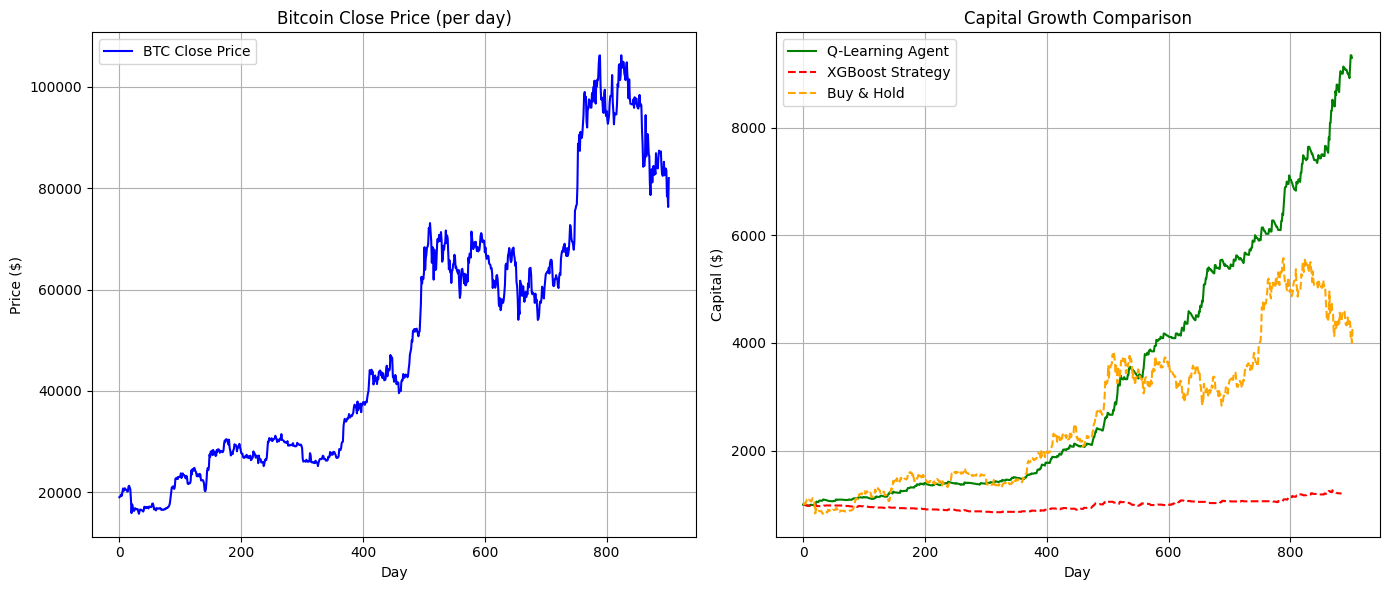

In [78]:
plot_results(df_agent, df_xgb)

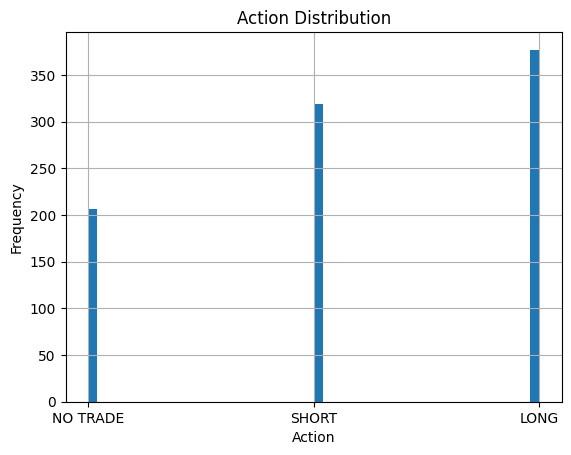

In [79]:
df_agent["Action"].hist(bins=50)
plt.title("Action Distribution")
plt.xlabel("Action")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

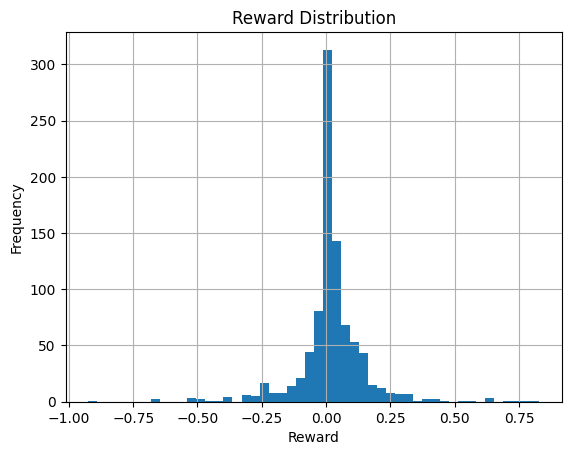

In [80]:
df_agent["Reward"].hist(bins=50)
plt.title("Reward Distribution")
plt.xlabel("Reward")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

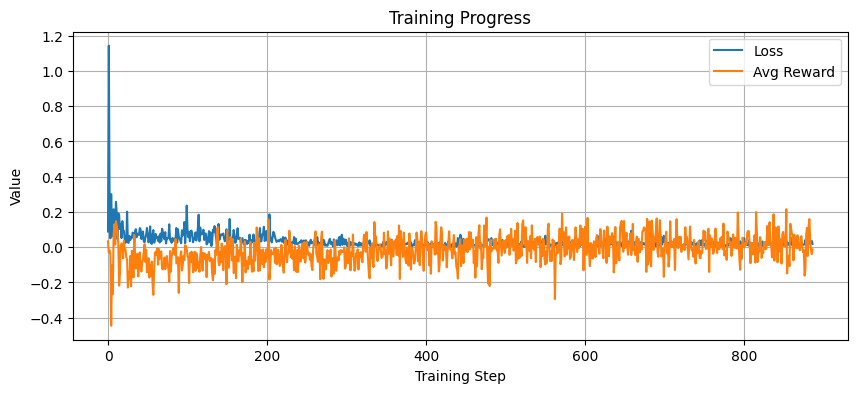

In [81]:
plt.figure(figsize=(10, 4))
plt.plot(df_loss["Step"], df_loss["Loss"], label="Loss")
plt.plot(df_loss["Step"], df_loss["Avg_Reward"], label="Avg Reward")
plt.xlabel("Training Step")
plt.ylabel("Value")
plt.title("Training Progress")
plt.legend()
plt.grid(True)
plt.show()

In [75]:
# Determining the best seed value

def objective(trial):
    seed = trial.suggest_int("seed", 1, 9999)
    set_seed(seed)

    df_agent, _ = run_agent()  # run_agent moet gedefinieerd zijn
    final_capital = df_agent.iloc[-1]["Capital"]
    return final_capital

# === Optuna run ===
if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=20)

    print("Best seed:", study.best_trial.params["seed"])
    print("Best capital:", study.best_value)

[I 2025-04-09 20:35:26,700] A new study created in memory with name: no-name-d3eb0c95-70d0-4dc8-b7b5-c00d4e764849
[I 2025-04-09 20:35:42,848] Trial 0 finished with value: 5895.6 and parameters: {'seed': 1692}. Best is trial 0 with value: 5895.6.
[I 2025-04-09 20:35:58,949] Trial 1 finished with value: 5516.49 and parameters: {'seed': 824}. Best is trial 0 with value: 5895.6.
[I 2025-04-09 20:36:15,328] Trial 2 finished with value: 6399.46 and parameters: {'seed': 2228}. Best is trial 2 with value: 6399.46.
[I 2025-04-09 20:36:31,442] Trial 3 finished with value: 6891.16 and parameters: {'seed': 4753}. Best is trial 3 with value: 6891.16.
[I 2025-04-09 20:36:47,579] Trial 4 finished with value: 5264.54 and parameters: {'seed': 3838}. Best is trial 3 with value: 6891.16.
[I 2025-04-09 20:37:03,756] Trial 5 finished with value: 9294.67 and parameters: {'seed': 2098}. Best is trial 5 with value: 9294.67.
[I 2025-04-09 20:37:20,009] Trial 6 finished with value: 6256.43 and parameters: {'see

Best seed: 2098
Best capital: 9294.67
